In [5]:
import os
import sys

import numpy as np
import math
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo as mc
import chirality_tools as chir
from numba import jit
from numba_progress import ProgressBar


ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

# Initialization

In [15]:
N = 100
a = params["lattice_constant"]


In [16]:
file_path = f'../data/q2_degeneracy/s{N}.csv'
trj_final = pd.read_csv(file_path, index_col=['realization','frame','id'])
trj = trj_final.loc[idx[1,:,:]]
trj

x           y    z            dx   dy   dz  \
frame id                                                           
0     0        4.187006    0.000000  0.0 -1.000000e+00 -0.0 -0.0   
      1       12.561017    0.000000  0.0 -1.000000e+00 -0.0 -0.0   
      2       20.935029    0.000000  0.0 -1.000000e+00 -0.0 -0.0   
      3       29.309040    0.000000  0.0  1.000000e+00  0.0  0.0   
      4       37.683052    0.000000  0.0 -1.000000e+00 -0.0 -0.0   
...                 ...         ...  ...           ...  ...  ...   
      19995  795.531096  833.214148  0.0  6.123234e-17  1.0  0.0   
      19996  803.905108  833.214148  0.0 -6.123234e-17 -1.0 -0.0   
      19997  812.279119  833.214148  0.0 -6.123234e-17 -1.0 -0.0   
      19998  820.653131  833.214148  0.0  6.123234e-17  1.0  0.0   
      19999  829.027142  833.214148  0.0  6.123234e-17  1.0  0.0   

                       cx   cy   cz  
frame id                             
0     0     -1.500000e+00 -0.0 -0.0  
      1     -1.500000e+00 -0.0 -0.0  
      2     -1.500000e+00 -0.0 -0.0  
      3      1.500000e+00  0.0  0.0  
      4     -1.500000e+00 -0.0 -0.0  
...                   ...  ...  ...  
      19995  9.184851e-17  1.5  0.0  
      19996 -9.184851e-17 -1.5 -0.0  
      19997 -9.184851e-17 -1.5 -0.0  
      19998  9.184851e-17  1.5  0.0  
      19999  9.184851e-17  1.5  0.0  

[20000 rows x 9 columns]

# Visualization

In [ ]:
fig, ax= plt.subplots(figsize=(20,20))


region_limit = N*params['lattice_constant'].magnitude
ice.draw_frame(trj, frame_no=0,
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

#mc.display_vertices(trj,N,a,ax)
mc.display_arrows(trj,N,a,ax)
#mc.display_lines(trj,N,a,ax)

plt.show()

# Magnetic Structure Factor


In [17]:
def reciprocal_space(N,a):
    kx = 2*np.pi*np.fft.fftshift( np.fft.fftfreq(N,d=a) )
    ky = 2*np.pi*np.fft.fftshift( np.fft.fftfreq(N,d=a) ) 

    KX, KY = np.meshgrid(kx,ky)
    N = len(kx)
    reciprocal_space = np.zeros((N,N,2))
    reciprocal_space[:,:,0] = KX
    reciprocal_space[:,:,1] = KY

    return reciprocal_space


In [18]:
centers, dirs, rels = mc.trj2numpy(trj)
vrt_lattice = mc.vertices_lattice(a.magnitude,N,spos=(0,0))
indices_matrix = mc.indices_lattice(vrt_lattice,centers,a.magnitude,N)
arrow_lattice = mc.dipole_lattice(centers,dirs,rels, vrt_lattice, indices_matrix)
reciprocal_lattice = reciprocal_space(N,a.magnitude)

In [19]:
pairwise_indices = np.array([[i,j] for i in range(N) for j in range(N)])

with ProgressBar(total=len(pairwise_indices)) as progress:
    msf = mc.magnetic_structure_factor(
        reciprocal_lattice,
        arrow_lattice,
        vrt_lattice,
        N,
        a.magnitude,
        pairwise_indices,
        progress)

  0%|          | 0/10000 [00:00<?, ?it/s]

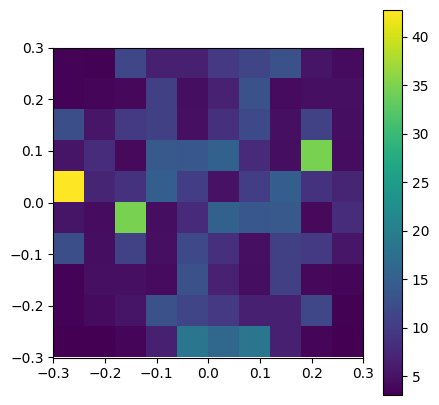

In [14]:
kedge = max(reciprocal_lattice[0,:,0])
fig, ax = plt.subplots(figsize=(5,5))
image = ax.imshow(msf, origin='lower', extent=[-kedge,kedge,-kedge,kedge])
fig.colorbar(image)

plt.show()

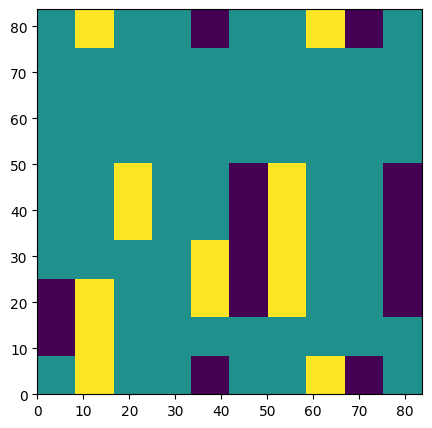

In [94]:
corr = mc.dipole_correlate(arrow_lattice,vrt_lattice,reference=(0,1))
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(corr, origin='lower',extent=[0,N*a.magnitude,0,N*a.magnitude])
#ax.set_xticks(vrt_lattice[:,0,0][::5])
#ax.set_yticks(vrt_lattice[:,0,0][::5])
plt.show()

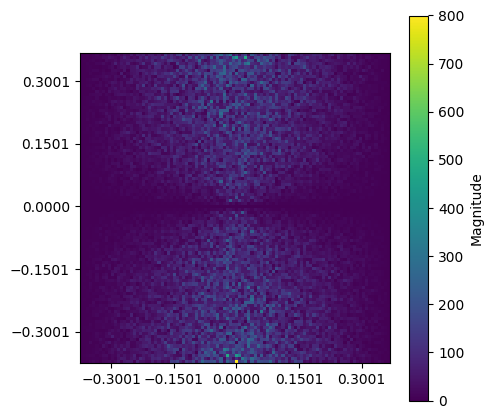

In [82]:
kx = 2*np.pi*np.fft.fftfreq(N,d=a.magnitude)
ky = 2*np.pi*np.fft.fftfreq(N,d=a.magnitude)

fft_corr = np.fft.fftshift( np.fft.fft2(corr) )

fig, ax = plt.subplots(figsize=(5,5))
image = ax.imshow(np.abs(fft_corr), origin='lower',extent=[min(kx),max(kx),min(ky),max(ky)])
ax.set_xticks(kx[::20])
ax.set_yticks(ky[::20])

fig.colorbar(image, label='Magnitude')

plt.show()

# Spin-Spin correlations

In [42]:
centers, dirs, rels = mc.trj2numpy(trj)
data_length = math.comb(len(centers),2) + len(centers)
data = mc.spin_spin_correlate(centers,dirs,rels,a.magnitude,N, data_length)

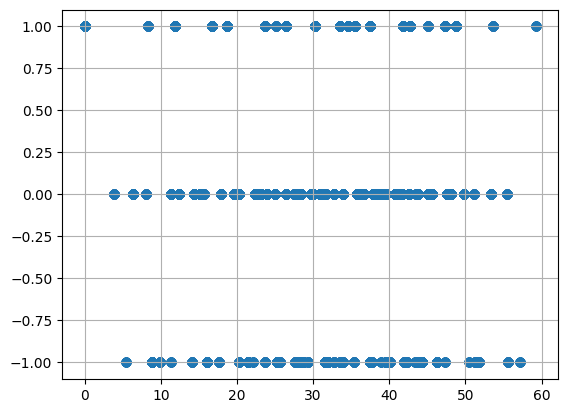

In [48]:
plt.scatter(data[:,3],data[:,2])
plt.grid()

In [61]:
df_data = pd.DataFrame(data, columns=['spin1','spin2','dot','distance'])
df_data['distance'] = df_data['distance'].round(3)


In [67]:
grouped_data = []
for d,dfi in df_data.groupby('distance'):
    av_corr = np.mean(dfi['dot'])
    grouped_data.append([d,av_corr])

grouped_data = np.array(grouped_data)

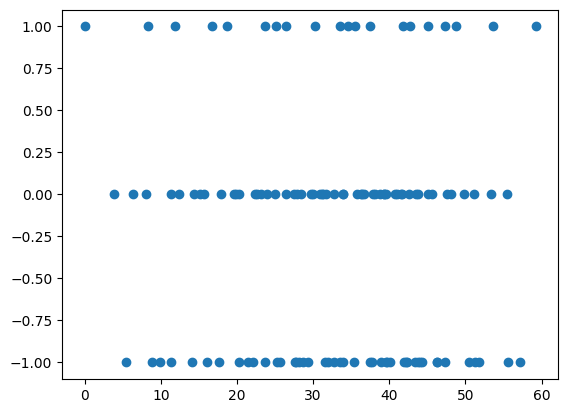

In [68]:
plt.scatter(grouped_data[:,0],grouped_data[:,1])

# dump

In [ ]:
def dipole_correlate(arrow_lattice,vrt_lattice, reference = (0,0)):
    
    rows, cols = arrow_lattice.shape[:2]
    correlations_lattice = np.zeros((rows,cols))
    
    dip_ref = arrow_lattice[reference]
    
    for i in range(rows):
        for j in range(cols):

            correlations_lattice[i,j]=np.dot(dip_ref,arrow_lattice[i,j])
    
    return correlations_lattice

# idk try to ignore this
@jit(nopython=True)
def spin_spin_correlate(centers,dirs,rels,a,N,data_length):
    
    L = N*a
    # loop thorugh all the pairs
    number_particles = len(dirs)
    correlations = np.zeros((data_length,4))

    idx = 0 # initialize
    for i in range(number_particles):
        for j in range(i,number_particles):

            Si = dirs[i]
            Sj = dirs[j]
            # absolute positions
            xi = centers[i] + rels[i]
            xj = centers[j] + rels[j]
            # spins and distance
            SiSj = Si[0]*Sj[0] + Si[1]*Sj[1] + Si[2]*Sj[2]
            distance_pbc = numba_pbc_distance(xi,xj,L)

            correlations[idx,:] = np.array([i,j,SiSj,distance_pbc])

            idx= idx + 1

    return correlations
